# where is floating?

##
### Datapaper plots

1. field_location.png Modis moa Inset map, ant in corner, icestreams scale, square of common border, include flow route,
2. geophysics_overview.png Map of all data presented
3. historic_channel.png Historic landsat images
4. thickness_surfacecolour.png Profile depth
6. 3D view of channel
7. radarlines 
8. channel_meander.png meander
11. ApRES include stress
9. Icesat1/REMA
10. Icesat2


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import sys
import time
import datetime as dt
import pandas as pd
import geopandas as gpd
import scipy as sp
from scipy import signal
from tqdm.notebook import tqdm
import rasterio as rio
from shapely.geometry import Point, LineString, Polygon, MultiPoint, box
import fiona
from shapely.ops import nearest_points
from rasterio.windows import Window
import string
import matplotlib.gridspec as gridspec

In [5]:
# Load ice base interpolated from radar results
direc = '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/interpolatedgrid_allchan'

xv = np.load(direc + 'x_grid' +'.npy')
yv = np.load(direc + 'y_grid' +'.npy')
thickness_interpolated = np.load(direc +'ice_thickness'+'.npy')
REMA_surf = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/highres_chan_surf.npy')

extent_l2l = np.load(direc +'extent.npy')
ice_base = np.load(direc +'_ice_base.npy')
ice_base_smooth = sp.ndimage.gaussian_filter(ice_base, sigma=30, order=0)

In [6]:
# from DATA/Jupyter/RADAR/RADAR_MAP/44_where_float.ipynb
sea_level_below_surf = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/sea_level_below_surf_2.npy')

In [7]:
geoid_correction = 47*np.ones(sea_level_below_surf.shape)
geoid_correction[sea_level_below_surf==0] =  np.nan

In [8]:
REMA_surf[sea_level_below_surf==0.0] = np.nan

In [9]:
sea_level_below_surf[sea_level_below_surf==0]=np.nan

In [10]:
xmin, xmax, ymin, ymax = -382700, -374781.9, -734075.1, -721770.2

In [11]:
#groundingline
bbox = box(xmin, xmax, ymin, ymax)
groundingline_path = glob.glob(f"/Volumes/arc_02/REMOTE_SENSING/Quantarctica3/Miscellaneous/ScrippsGroundingLine/*.shp")[0]
groundingline =  gpd.read_file(groundingline_path)
# groundingline_path

groundingline = groundingline[groundingline.geometry.intersects(bbox)].copy()

coast = groundingline.geometry.iloc[0].exterior.coords[:]

gl = np.array([[x,y] for x,y in coast ])

gl = gl[(gl[:,0]< xmax) & (gl[:,0]> xmin) & (gl[:,1] > ymin) & (gl[:,1] <  ymax)].copy()

In [12]:
# plt.imshow(REMA_surf,vmin=20,vmax=100)
# plt.colorbar()

In [13]:
# plt.imshow(sea_level_below_surf)
# plt.colorbar()

In [14]:
# plt.imshow(geoid_correction)
# plt.colorbar()

In [15]:
atfloat_sea_level_from_geoid = REMA_surf+geoid_correction - sea_level_below_surf
# atfloat_sea_level_from_geoid = atfloat_sea_level_from_geoid[sea_level_below_surf!=0]

In [16]:
yticks = (np.linspace(-734000,-722000,4)/1000).astype(int)
xticks = (np.linspace(-382000,-376000,4)/1000).astype(int)

In [17]:
af_smoo = sp.ndimage.gaussian_filter(atfloat_sea_level_from_geoid, sigma=10, order=0)


In [18]:
#colormap
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [19]:
# def plot_examples(colormaps):
#     """
#     Helper function to plot data with associated colormap.
#     """
#     np.random.seed(19680801)
#     data = np.random.randn(30, 30)
#     n = len(colormaps)
#     fig, axs = plt.subplots(1, n, figsize=(n * 2 + 2, 3),
#                             constrained_layout=True, squeeze=False)
#     for [ax, cmap] in zip(axs.flat, colormaps):
#         psm = ax.pcolormesh(data, cmap=cmap, rasterized=True, vmin=-1, vmax=4.5)
#         fig.colorbar(psm, ax=ax)
#     plt.show()

In [20]:
# inferno = cm.get_cmap('inferno', 450)
# inferno_arr = inferno(np.linspace(0, 1, 450))
# winter = cm.get_cmap('winter_r', 100)
# winter_arr = winter(np.linspace(0, 1, 100))

# newcolors = np.vstack((winter_arr,inferno_arr))

# newcmp = ListedColormap(newcolors, name='inf_w_o')

In [22]:
winter = cm.get_cmap('winter_r', 100)
winter_arr = winter(np.linspace(0, 1, 100))

N=30

inferno = cm.get_cmap('inferno', 450-N)
inferno_arr = inferno(np.linspace(0, 1, 450-N))


blend = np.ones((N, 4))
blend[:, 0] = np.linspace(winter_arr[-1][0],inferno(0)[0], N)
blend[:, 1] = np.linspace(winter_arr[-1][1],inferno(0)[1], N)
blend[:, 2] = np.linspace(winter_arr[-1][2],inferno(0)[2], N)

newcolors = np.vstack((winter_arr,blend,inferno_arr))

newcmp = ListedColormap(newcolors, name='inf_w_o')

# plot_examples([newcmp])

In [23]:
winter_arr[0]

array([0. , 1. , 0.5, 1. ])

In [24]:
# inferno = cm.get_cmap('inferno', 450)
# newcolor = inferno(np.linspace(0, 1, 450))

# i_zero = 50

# N=100
# vals = np.ones((N, 4))
# vals[:N//2, 0] = np.linspace(inferno(i_zero)[0], 1, N//2)
# vals[:N//2, 1] = np.linspace(inferno(i_zero)[1], 1, N//2)
# vals[:N//2, 2] = np.linspace(inferno(i_zero)[2], 1, N//2)
# vals[N//2:, 0] = np.linspace(1,inferno(i_zero)[0], N//2)
# vals[N//2:, 1] = np.linspace(1,inferno(i_zero)[1], N//2)
# vals[N//2:, 2] = np.linspace(1,inferno(i_zero)[2],  N//2)

# newcolors = np.vstack((newcolor[:i_zero],vals,newcolor[i_zero:]))

# newcmp = ListedColormap(newcolors, name='inf_w_o')

# plot_examples([newcmp])

In [25]:
# bwr_top = cm.get_cmap('bwr', 900) 
# bwr_bottom = cm.get_cmap('bwr', 200)
# newcolor_top = bwr_top(np.linspace(0, 1, 900))[450:]
# newcolor_bottom = bwr_bottom(np.linspace(0, 1, 200))[:100]

# newcolors = np.vstack((newcolor_bottom,newcolor_top))

# newcmp = ListedColormap(newcolors, name='inf_w_o')

In [26]:
# plot_examples([newcmp])

In [27]:
# plt.figure( dpi=180,figsize=(6,8))
# plt.text(0.1, 0.7, 'A')

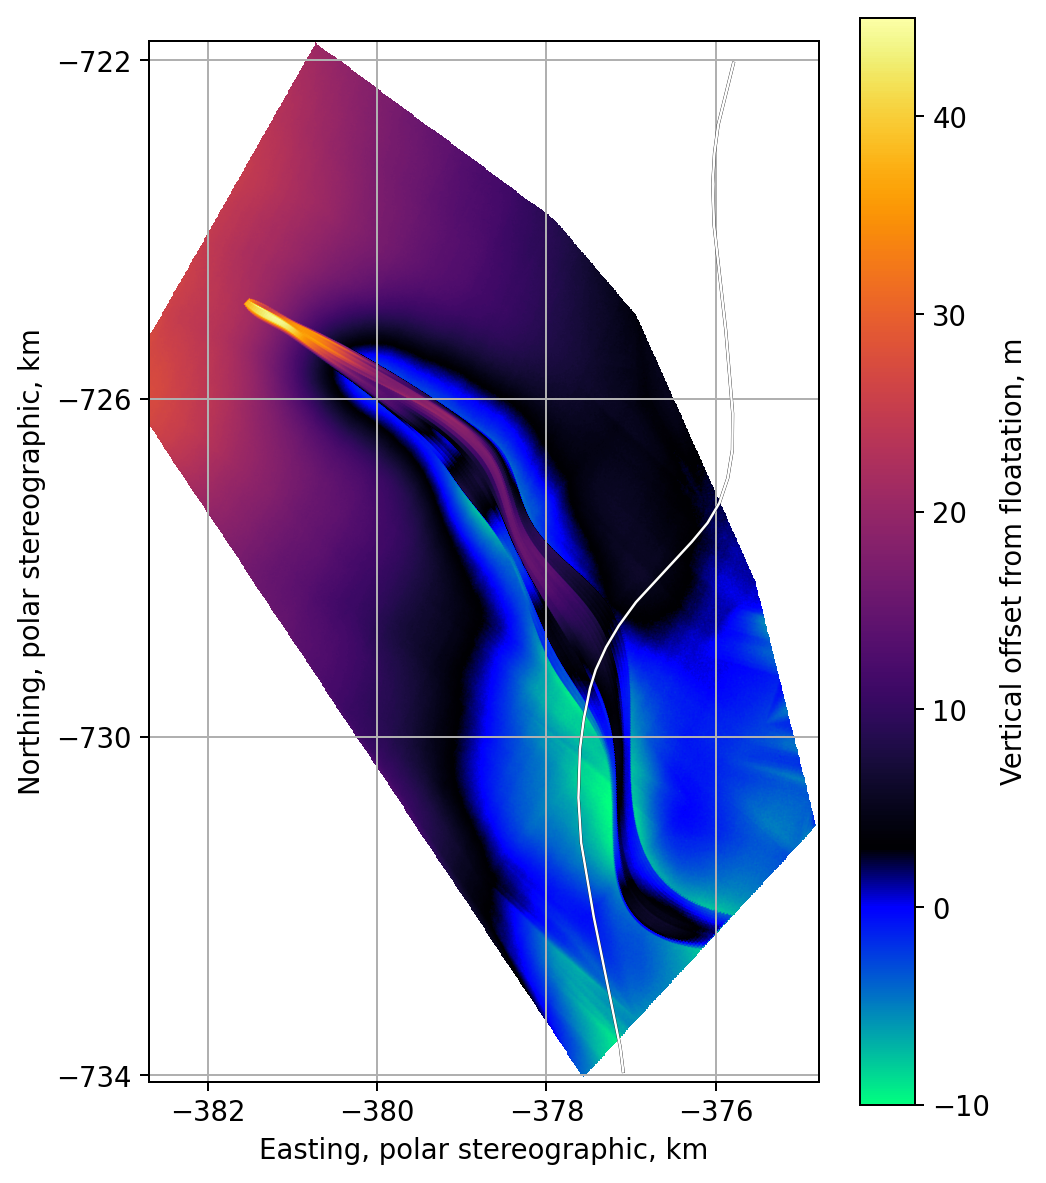

In [28]:
plt.figure( dpi=180,figsize=(6,8))

plt.rcParams.update({'font.size': 11})

plt.imshow(atfloat_sea_level_from_geoid,extent=np.array(extent_l2l/1000),cmap=newcmp,vmin=-10,vmax=45)

plt.plot(gl[:,0]/1000,gl[:,1]/1000,'k-',label='grounding line',linewidth=1.2)
plt.plot(gl[:,0]/1000,gl[:,1]/1000,'w-',label='grounding line',linewidth=1)

# plt.annotate( 'A',(-381.3, -725.1))

plt.xlim([xmin/1000,xmax/1000])

plt.ylim([ymin/1000,ymax/1000])

cb3 = plt.colorbar()
cb3.set_label('Vertical offset from floatation, m')
# cb3.set_ticks(np.round(np.linspace(-350,-700,5)/5)*5)
plt.xlim([xmin/1000,xmax/1000])

plt.ylim([ymin/1000,ymax/1000])

plt.xticks(xticks)
plt.yticks(yticks)
plt.xlabel('Easting, polar stereographic, km')
plt.ylabel('Northing, polar stereographic, km')

plt.grid()

plt.savefig('/Users/home/whitefar/ASSIGNMENTS-PUBLICATIONS-TALKS/channel_data_writeup/PLOTS/where_float.png')

plt.show()

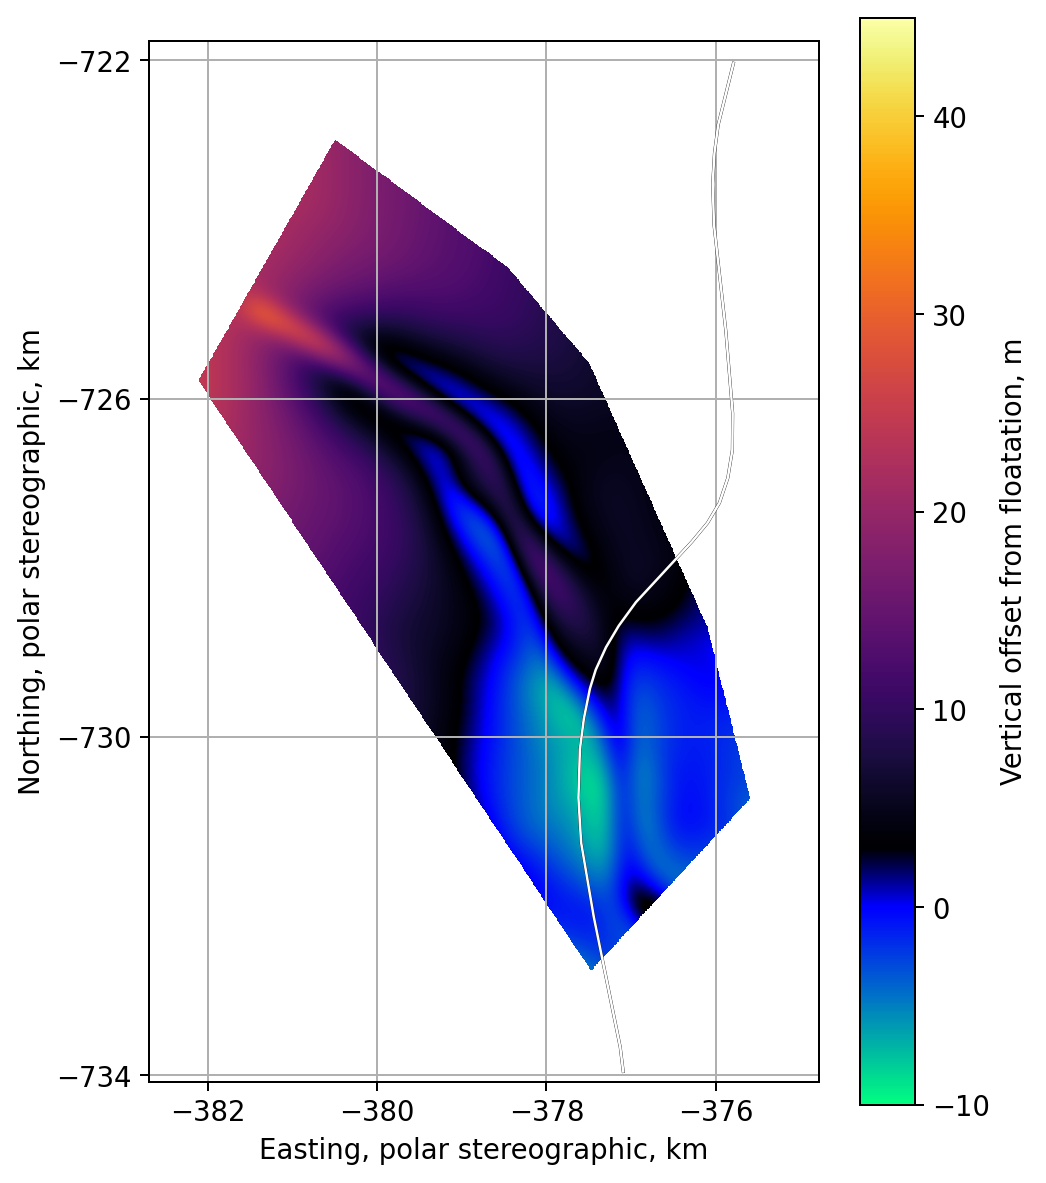

In [35]:
plt.figure( dpi=180,figsize=(6,8))

plt.rcParams.update({'font.size': 11})

plt.imshow(sp.ndimage.gaussian_filter(atfloat_sea_level_from_geoid, sigma=70),extent=np.array(extent_l2l/1000),cmap=newcmp,vmin=-10,vmax=45)

plt.plot(gl[:,0]/1000,gl[:,1]/1000,'k-',label='grounding line',linewidth=1.2)
plt.plot(gl[:,0]/1000,gl[:,1]/1000,'w-',label='grounding line',linewidth=1)

# plt.annotate( 'A',(-381.3, -725.1))

plt.xlim([xmin/1000,xmax/1000])

plt.ylim([ymin/1000,ymax/1000])

cb3 = plt.colorbar()
cb3.set_label('Vertical offset from floatation, m')
# cb3.set_ticks(np.round(np.linspace(-350,-700,5)/5)*5)
plt.xlim([xmin/1000,xmax/1000])

plt.ylim([ymin/1000,ymax/1000])

plt.xticks(xticks)
plt.yticks(yticks)
plt.xlabel('Easting, polar stereographic, km')
plt.ylabel('Northing, polar stereographic, km')

plt.grid()

# plt.savefig('/Users/home/whitefar/ASSIGNMENTS-PUBLICATIONS-TALKS/channel_data_writeup/PLOTS/where_float.png')

plt.show()

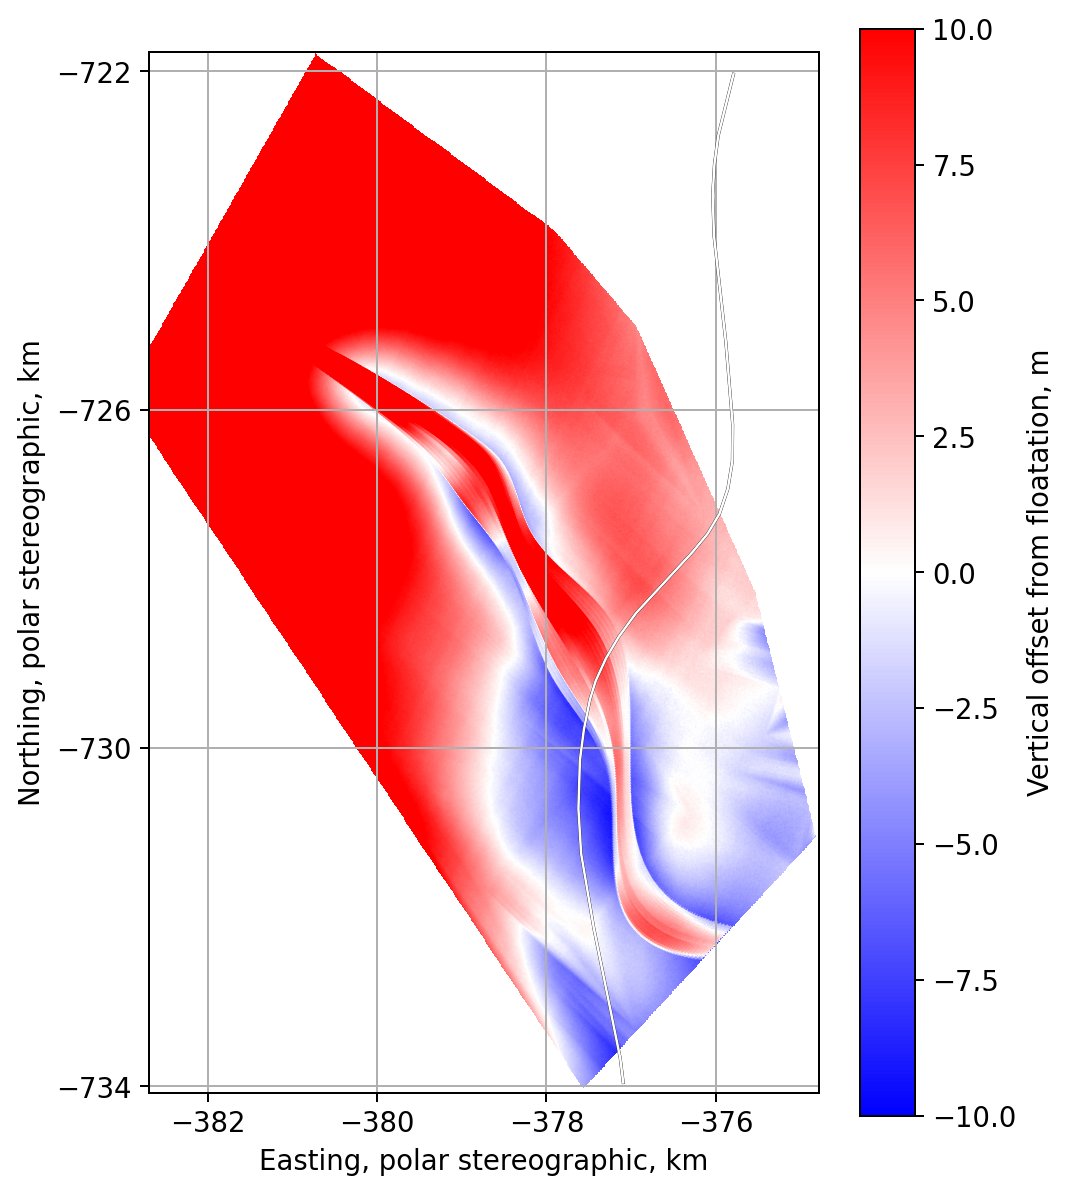

In [112]:
plt.figure( dpi=180,figsize=(6,8))

plt.rcParams.update({'font.size': 11})

plt.imshow(atfloat_sea_level_from_geoid,extent=np.array(extent_l2l/1000),cmap='bwr',vmin=-10,vmax=45)

plt.plot(gl[:,0]/1000,gl[:,1]/1000,'k-',label='grounding line',linewidth=1.2)
plt.plot(gl[:,0]/1000,gl[:,1]/1000,'w-',label='grounding line',linewidth=1)


plt.xlim([xmin/1000,xmax/1000])

plt.ylim([ymin/1000,ymax/1000])

cb3 = plt.colorbar()
cb3.set_label('Vertical offset from floatation, m')
# cb3.set_ticks(np.round(np.linspace(-350,-700,5)/5)*5)
plt.xlim([xmin/1000,xmax/1000])

plt.ylim([ymin/1000,ymax/1000])

plt.xticks(xticks)
plt.yticks(yticks)
plt.xlabel('Easting, polar stereographic, km')
plt.ylabel('Northing, polar stereographic, km')

plt.grid()



plt.show()

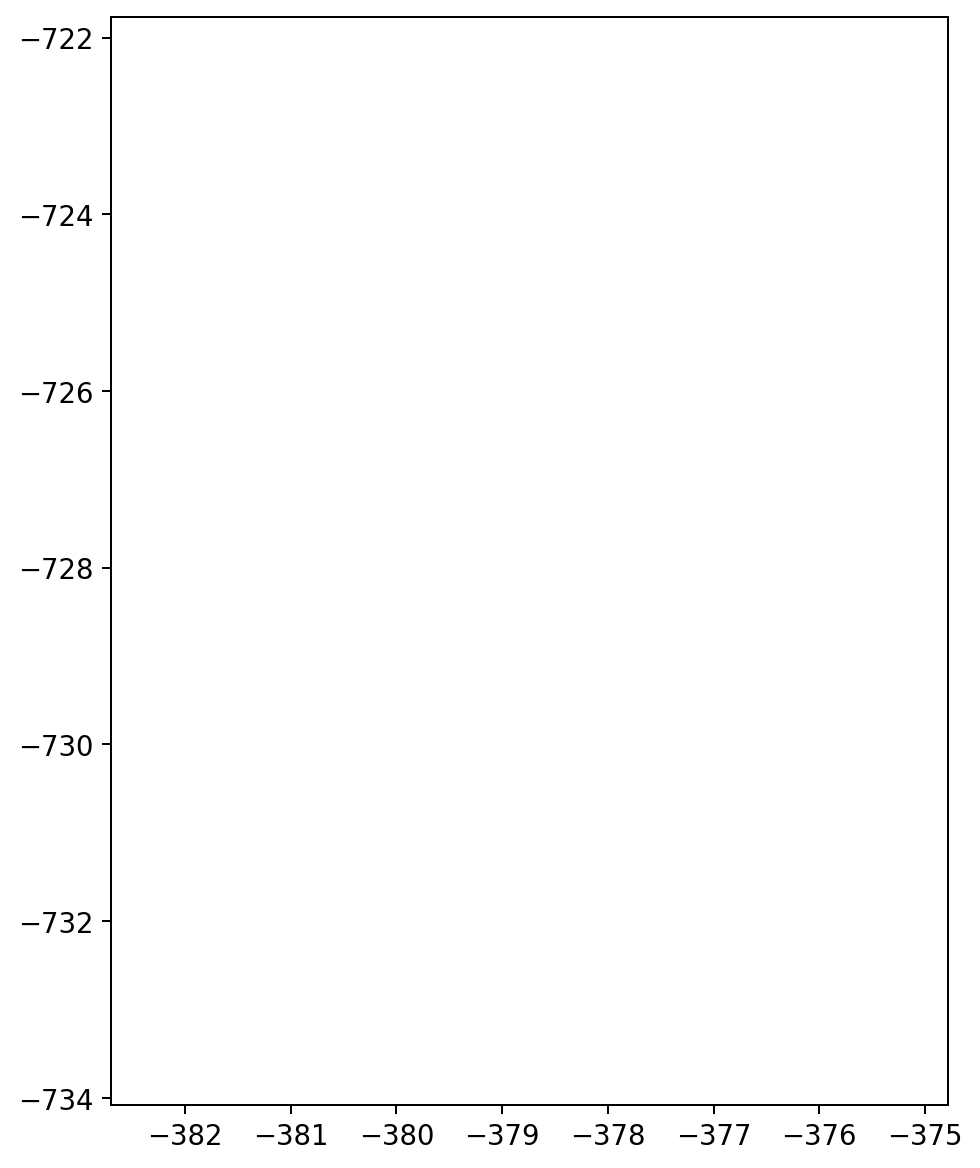

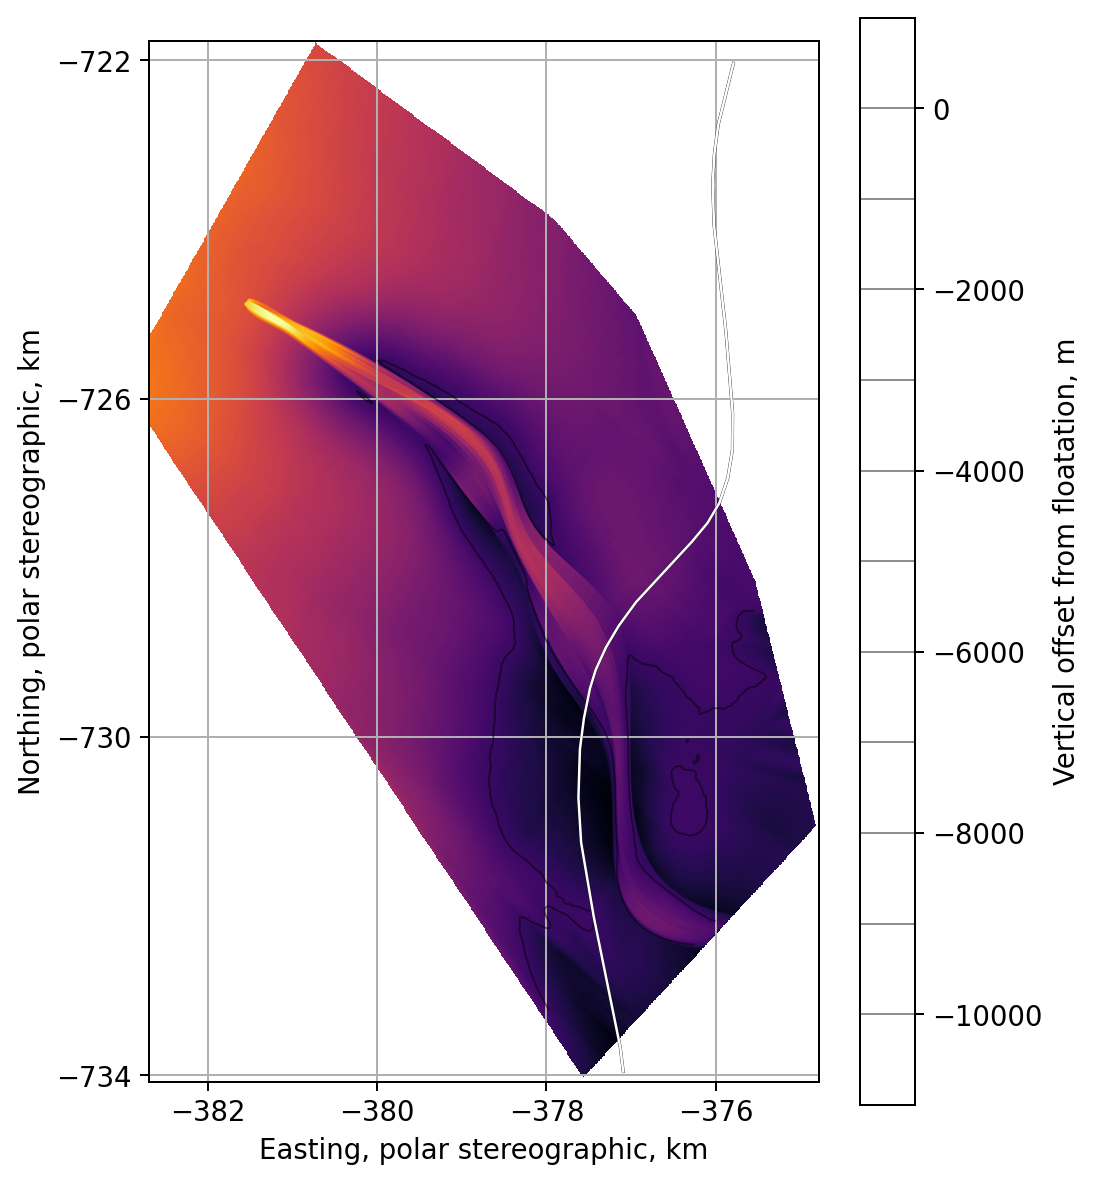

In [113]:
plt.figure( dpi=180,figsize=(6,8))

# plt.clabel(CS,CS.levels, inline=1,  fmt='%i')
plt.xlim([xmin/1000,xmax/1000])
plt.ylim([ymin/1000,ymax/1000])
plt.figure( dpi=180,figsize=(6,8))

plt.rcParams.update({'font.size': 11})

plt.imshow(atfloat_sea_level_from_geoid,extent=np.array(extent_l2l/1000),cmap='inferno',vmin=-10,vmax=45)


# #C base with surface contours
samp = 10
CS =  plt.contour(xv[::samp]/1000,yv[::samp]/1000,af_smoo[::samp],
                  10,
                   vmin=-15,vmax=40, 
#                   cmap='BrBG',
                  colors='black',
                  alpha=0.5,linewidths=0.7)

plt.plot(gl[:,0]/1000,gl[:,1]/1000,'k-',label='grounding line',linewidth=1.2)
plt.plot(gl[:,0]/1000,gl[:,1]/1000,'w-',label='grounding line',linewidth=1)


plt.xlim([xmin/1000,xmax/1000])

plt.ylim([ymin/1000,ymax/1000])

cb3 = plt.colorbar()
cb3.set_label('Vertical offset from floatation, m')
# cb3.set_ticks(np.round(np.linspace(-350,-700,5)/5)*5)
plt.xlim([xmin/1000,xmax/1000])

plt.ylim([ymin/1000,ymax/1000])

plt.xticks(xticks)
plt.yticks(yticks)
plt.xlabel('Easting, polar stereographic, km')
plt.ylabel('Northing, polar stereographic, km')

plt.grid()



plt.show()

/Users/home/whitefar/miniconda3/envs/remote_sensing/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


([<matplotlib.axis.XTick at 0x7fecd848de50>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

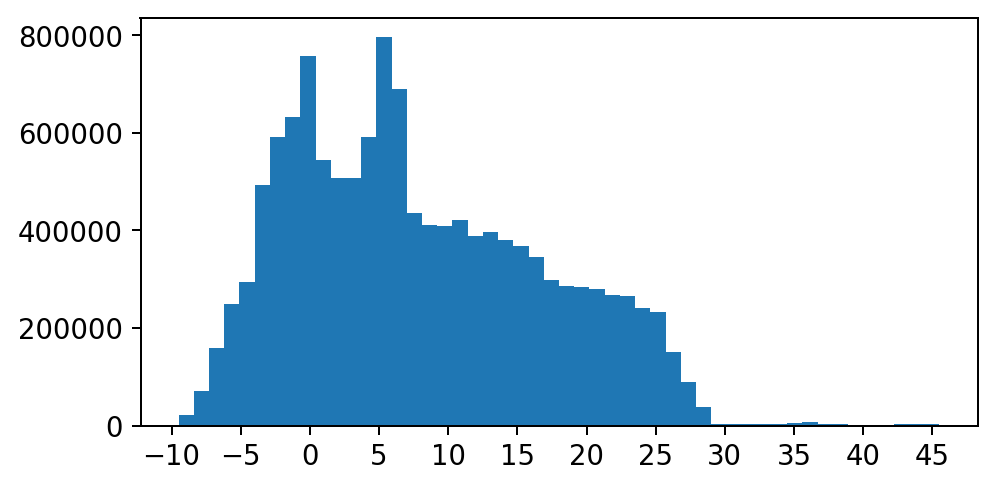

In [45]:
plt.figure( dpi=180,figsize=(6,3))

n, bins, patches = plt.hist(atfloat_sea_level_from_geoid[atfloat_sea_level_from_geoid>-2000],50)
plt.xticks(np.arange(-10,50,5))

In [47]:
np.mean(atfloat_sea_level_from_geoid[atfloat_sea_level_from_geoid>-2000])

/Users/home/whitefar/miniconda3/envs/remote_sensing/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


7.916772591562311